# TCGAのデータを使ってKaplanMeier生存曲線を作る

---

`lifelines`モジュールを使いますので、インストールします。  
公式ドキュメントの使い方の説明がとてもわかりやすいです。  
https://lifelines.readthedocs.io/en/latest/index.html  

TCGAから臨床データを取得します。  
今回は肺がんデータを使います。  

TCGA  
https://portal.gdc.cancer.gov/

Repositoryから  
Cases  
&emsp;Program: TCGA  
&emsp;Project: TCGA-LUSC  
Files  
&emsp;Experimental Strategy: WXS  
&emsp;Access: Open  
にチェックをいれ、Add All Files to CartをクリックしてからCartに移動します。  

Clinicalのボタンをクリックし、ファイルをダウンロードします。  
解凍(tar -xvzf ファイル名)して得られたclinical.tsvファイルを使用します。  

データフレームを駆使して必要な情報を取得してもよいですが、  
必要なデータだけピックアップした新しいファイルを作ったほうがわかりやすいので、  
ここでは以下のようにして新しいファイルを作成します。  

In [1]:
import re
with open('clinical.tsv') as f:
    header, *lines = f.readlines()
    data = {}
    for line in lines:
        cols = line.strip().split('\t')
        if cols[15] == 'Alive' and re.search(r'\d+', cols[47]): #cols[47] days_to_last_follow_up
            data.setdefault(cols[1], f'{int(cols[47]) // 30}\t0') 
        elif cols[15] == 'Dead' and re.search(r'\d+', cols[9]): #cols[9] days_to_death
            data.setdefault(cols[1], f'{int(cols[9]) // 30}\t1')
        else:
            print(line) #欠損値があれば出力する
    
with open('clinical_edited.tsv', 'w') as out:
    print('T', 'E', sep='\t', file=out)
    for value in data.values():
        print(value, file=out)  

68107725-a883-4b33-a366-d9b4adb18028	TCGA-63-5131	TCGA-LUSC	'--	'--	'--	'--	'--	'--	'--	not reported	male	'--	'--	not reported	Dead	'--	'--	'--	'--	'--	'--	'--	'--	M0	N1	Stage IIB	T2	6th	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	not reported	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	C34.9	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	not reported	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	8070/3	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	Squamous cell carcinoma, NOS	'--	no	No	not reported	'--	'--	'--	Lung, NOS	'--	'--	No	Lung, NOS	'--	'--	'--	'--	not reported	'--	'--	stage iib	'--	'--	'--	'--	'--	'--	2008	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	no	'--	Radiation Therapy, NOS

68107725-a883-4b33-a366-d9b4adb18028	TCGA-63-5131	TCGA-LUSC	'--	'--	'--	'--	'--	'--	'--	not reported	male	'--	'--	not reported	Dead	'--	'--	'--	'--	'--	'--	'--	'--	M0	N1	Stage IIB	T2	6th	'--	'--	'--	'--	'--	'--	'

結構欠損値があるようです。  
必要なデータだけ記載された`clinical_edited.tsv`ファイルが作成されました。

In [2]:
import pandas as pd
df = pd.read_table('clinical_edited.tsv')

In [3]:
df

,T,E
0,112,0
1,27,1
2,90,0
3,19,0
4,120,1
...,...,...
486,22,1
487,18,0
488,34,0
489,5,1


In [4]:
T = df['T']
E = df['E']

<AxesSubplot:xlabel='timeline'>

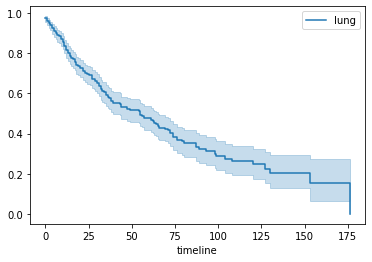

In [5]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label='lung')
kmf.survival_function_
kmf.plot_survival_function()

stageI, IIとstage III, IVで分けて曲線を書いてみます。  
先ほどと同じように、必要なデータだけピックアップしたファイルを作成します。  
> caseによってAJCCのeditionが異なるので、実際に使う際は注意してください。

In [6]:
with open('clinical.tsv') as f:
    header, *lines = f.readlines()
    data = {}
    for line in lines:
        cols = line.strip().split('\t')
        if cols[15] == 'Alive' and re.search(r'\d+', cols[47]): #cols[47] days_to_last_follow_up
            if match := re.match('Stage (\w+)', cols[26]): #ウォルラス演算子 python3.8以降
                stage = match.group(1)
                if stage == 'I' or stage == 'IA' or stage == 'IB' or stage == 'II' or stage == 'IIA' or stage == 'IIB':
                    data.setdefault(cols[1], f'{int(cols[47]) // 30}\t0\tstageI-II') 
                else:
                    data.setdefault(cols[1], f'{int(cols[47]) // 30}\t0\tstageIII-IV') 
            else:
                print(line) #欠損値を出力
                
        elif cols[15] == 'Dead' and re.search(r'\d+', cols[9]): #cols[9] days_to_death
            if match := re.match('Stage (\w+)', cols[26]):
                stage = match.group(1)
                if stage == 'I' or stage == 'IA' or stage == 'IB' or stage == 'II' or stage == 'IIA' or stage == 'IIB':
                    data.setdefault(cols[1], f'{int(cols[9]) // 30}\t1\tstageI-II') 
                else:
                    data.setdefault(cols[1], f'{int(cols[9]) // 30}\t1\tstageIII-IV') 
            else:
                print(line) #欠損値を出力
        else:
            print(line) #欠損値を出力
    
with open('clinical_group.tsv', 'w') as out:
    print('T', 'E', 'group', sep='\t', file=out)
    for value in data.values():
        print(value, file=out)  

68107725-a883-4b33-a366-d9b4adb18028	TCGA-63-5131	TCGA-LUSC	'--	'--	'--	'--	'--	'--	'--	not reported	male	'--	'--	not reported	Dead	'--	'--	'--	'--	'--	'--	'--	'--	M0	N1	Stage IIB	T2	6th	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	not reported	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	C34.9	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	not reported	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	8070/3	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	Squamous cell carcinoma, NOS	'--	no	No	not reported	'--	'--	'--	Lung, NOS	'--	'--	No	Lung, NOS	'--	'--	'--	'--	not reported	'--	'--	stage iib	'--	'--	'--	'--	'--	'--	2008	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	'--	no	'--	Radiation Therapy, NOS

68107725-a883-4b33-a366-d9b4adb18028	TCGA-63-5131	TCGA-LUSC	'--	'--	'--	'--	'--	'--	'--	not reported	male	'--	'--	not reported	Dead	'--	'--	'--	'--	'--	'--	'--	'--	M0	N1	Stage IIB	T2	6th	'--	'--	'--	'--	'--	'--	'

`clinical_group.tsv`ファイルが作成されました。  
KaplanMeier曲線を作成していきます。  

In [7]:
df = pd.read_table('clinical_group.tsv')

In [8]:
df

,T,E,group
0,112,0,stageI-II
1,27,1,stageI-II
2,90,0,stageI-II
3,19,0,stageI-II
4,120,1,stageI-II
...,...,...,...
482,22,1,stageI-II
483,18,0,stageI-II
484,34,0,stageI-II
485,5,1,stageI-II


In [9]:
T12 = df.loc[df['group'] == 'stageI-II', 'T']
E12 = df.loc[df['group'] == 'stageI-II', 'E']

T34 = df.loc[df['group'] == 'stageIII-IV', 'T']
E34 = df.loc[df['group'] == 'stageIII-IV', 'E']

In [10]:
E12

0      0
1      1
2      0
3      0
4      1
      ..
482    1
483    0
484    0
485    1
486    0
Name: E, Length: 397, dtype: int64

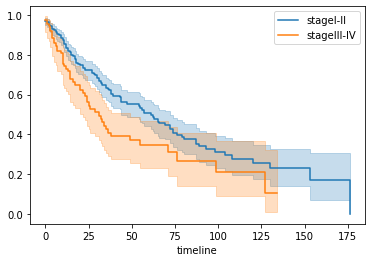

In [11]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

kmf.fit(T12, event_observed=E12, label='stageI-II')
ax = kmf.plot()

kmf.fit(T34, event_observed=E34, label='stageIII-IV')
ax = kmf.plot()